In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from python_speech_features import mfcc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPool2D,
                                     GlobalAveragePooling2D, Dense, Dropout, Flatten)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# fijamos semilla
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
class Config:
    def __init__(self, mode='time', nfilt=26, nfeat=13, nfft=4096, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

config = Config(mode='time')

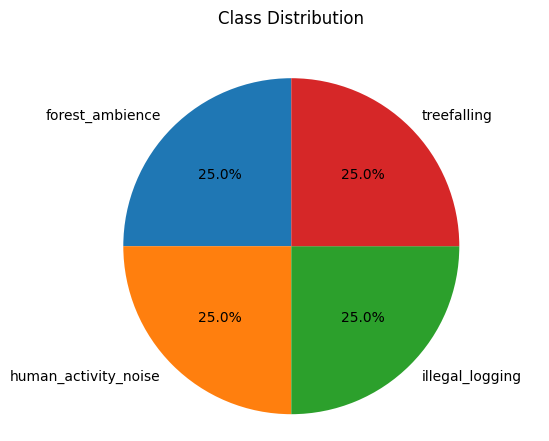

In [3]:
df = pd.read_csv('dataset_balanceado_2.csv')
df.set_index('filename', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('dataset_wavfiles/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [4]:
import math

def build_rand_feat():
    X_list = []
    y_list = []

    # Parámetros MFCC (python_speech_features por defecto)
    winlen = 0.025
    winstep = 0.01
    numcep = config.nfeat

    # calcular número esperado de frames por cada sample (segundos = step / rate)
    step_seconds = config.step / config.rate
    expected_frames = int(math.floor((step_seconds - winlen) / winstep) + 1) if step_seconds > winlen else 1
    # podemos usar expected_frames como tamaño fijo; si quieres otro valor, cambia aquí
    target_frames = expected_frames

    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('dataset_wavfiles/'+file)

        # stereo -> mono
        if wav.ndim == 2:
            wav = wav.mean(axis=1)
        # asegurar float32 y escala relativa (opcional)
        wav = wav.astype(np.float32)
        # normalizar amplitud si están en int16 por ejemplo (opcional)
        # if wav.dtype == np.int16:
        #     wav = wav / 32768.0

        label = df.at[file, 'label']

        # cortar/pad para tener exactamente config.step muestras (ya lo hacías)
        if wav.shape[0] < config.step:
            pad_width = config.step - wav.shape[0]
            wav = np.pad(wav, (0, pad_width), mode='constant')
        if wav.shape[0] == config.step:
            sample = wav
        else:
            start = np.random.randint(0, wav.shape[0] - config.step)
            sample = wav[start:start + config.step]

        # MFCC: devuelve (n_frames, numcep) -> transponemos a (numcep, frames)
        mfcc_feat = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        # mfcc_feat.shape == (numcep, n_frames_variable)

        # --- Asegurar forma homogénea: padding o truncado en axis temporal (axis=1)
        if mfcc_feat.shape[1] < target_frames:
            pad_w = target_frames - mfcc_feat.shape[1]
            mfcc_feat = np.pad(mfcc_feat, ((0,0),(0,pad_w)), mode='constant')
        elif mfcc_feat.shape[1] > target_frames:
            mfcc_feat = mfcc_feat[:, :target_frames]

        # Dependiendo del modo, guardamos de forma consistente
        if config.mode == 'conv':
            # Guardamos (numcep, frames) -> luego reshape a (numcep, frames, 1)
            X_list.append(mfcc_feat)
        elif config.mode == 'time':
            # LSTM/TimeDistributed espera (frames, numcep)
            X_list.append(mfcc_feat.T)
        elif config.mode == 'vector':
            # vector fijo: promedio sobre frames -> shape (numcep,)
            X_list.append(np.mean(mfcc_feat, axis=1))
        else:
            raise ValueError("config.mode debe ser 'conv', 'time' o 'vector'")

        y_list.append(classes.index(label))

    # Convertir a numpy (ahora todas las entradas son homogéneas)
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)

    # Normalización global (evita usar _min/_max mal calculados)
    X_min = X.min()
    X_max = X.max()
    X = (X - X_min) / (X_max - X_min + 1e-9)

    # Ajustar shapes para keras
    if config.mode == 'conv':
        # X tiene shape (N, numcep, frames) -> queremos (N, numcep, frames, 1)
        X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
    elif config.mode == 'time':
        # X está (N, frames, numcep) -> OK para LSTM/TimeDistributed
        pass
    elif config.mode == 'vector':
        # X está (N, numcep) -> OK para Dense
        pass

    y = to_categorical(y, num_classes=len(classes))
    return X, y, X_min, X_max, target_frames

X, y, X_min, X_max, target_frames = build_rand_feat()

100%|██████████| 158000/158000 [17:03<00:00, 154.36it/s]


In [20]:
# Guardar todo en un archivo comprimido
np.savez_compressed(
    "features_dataset_2.npz",
    X=X,
    y=y,
    X_min=X_min,
    X_max=X_max,
    target_frames=target_frames
)

print("✅ Features guardadas en features_dataset_2.npz")


✅ Features guardadas en features_dataset_2.npz


In [21]:
# Cargar el archivo
data = np.load("features_dataset_2.npz", allow_pickle=True)

# Recuperar variables
X = data["X"]
y = data["y"]
X_min = data["X_min"].item()
X_max = data["X_max"].item()
target_frames = data["target_frames"].item()

print("✅ Features cargadas. Shape X:", X.shape, "Shape y:", y.shape)

✅ Features cargadas. Shape X: (158000, 8, 13) Shape y: (158000, 4)


In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (101120, 8, 13) (101120, 4)
Val: (25280, 8, 13) (25280, 4)
Test: (31600, 8, 13) (31600, 4)


In [6]:
y_flat = np.argmax(y, axis=1)
# class weights SOLO con y en enteros
class_weight_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_flat),
    y=y_flat
)
class_weight = dict(zip(np.unique(y_flat), class_weight_vals))

In [7]:
from tensorflow.keras import layers, models

def get_tiny_lstm(input_shape, num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Capa LSTM pequeña
    x = layers.LSTM(32, return_sequences=True)(inputs)
    x = layers.Dropout(0.3)(x)

    # Otra LSTM más chica
    x = layers.LSTM(16)(x)
    x = layers.Dropout(0.3)(x)

    # Capa densa pequeña
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 8, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 8, 32)          │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,700 (37.89 KB)

 Trainable params: 9,700 (37.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.4578 - loss: 1.1910 - val_accuracy: 0.5214 - val_loss: 1.0841 - learning_rate: 0.0010
Epoch 2/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5349 - loss: 1.0708 - val_accuracy: 0.5714 - val_loss: 0.9917 - learning_rate: 0.0010
Epoch 3/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5760 - loss: 0.9949 - val_accuracy: 0.5997 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 4/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6001 - loss: 0.9521 - val_accuracy: 0.6126 - val_loss: 0.9045 - learning_rate: 0.0010
Epoch 5/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6170 - loss: 0.9211 - val_accuracy: 0.6352 - val_loss: 0.8584 - learning_rate: 0.0010
Epoch 6/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6257 - loss: 0.9021 - val_accuracy: 0.6440 - val_loss: 0.8394 - learning_rate: 0.0010
Epoch 7/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6

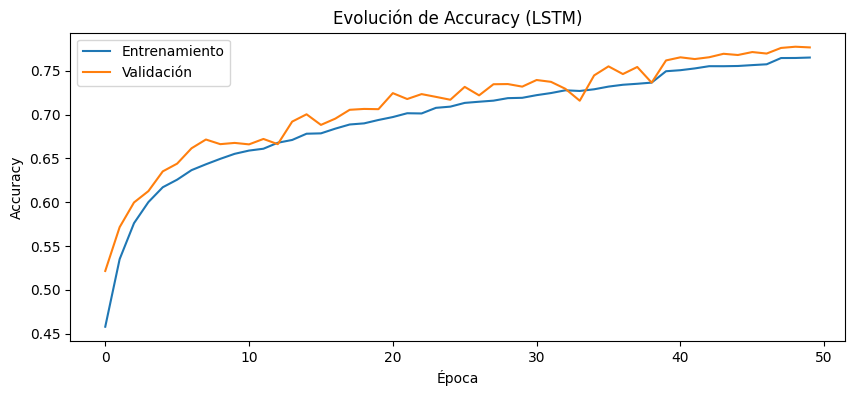

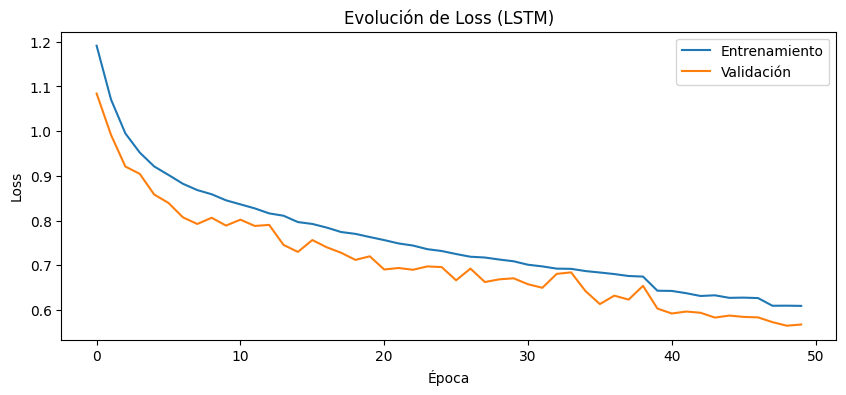

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2]) 
model = get_tiny_lstm(input_shape=input_shape, num_classes=4)
model.summary()

# Callbacks para controlar entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Entrenar
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

# --- Graficar métricas ---
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de Accuracy (LSTM)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de Loss (LSTM)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

988/988 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7829 - loss: 0.5555
Test Accuracy: 0.7829, Test Loss: 0.5555
988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:

                      precision    recall  f1-score   support

     forest_ambience     0.7509    0.7337    0.7422      7898
human_activity_noise     0.7235    0.6715    0.6965      7754
     illegal_logging     0.8369    0.7936    0.8147      7922
         treefalling     0.8121    0.9282    0.8663      8026

            accuracy                         0.7829     31600
           macro avg     0.7809    0.7818    0.7799     31600
        weighted avg     0.7813    0.7829    0.7807     31600



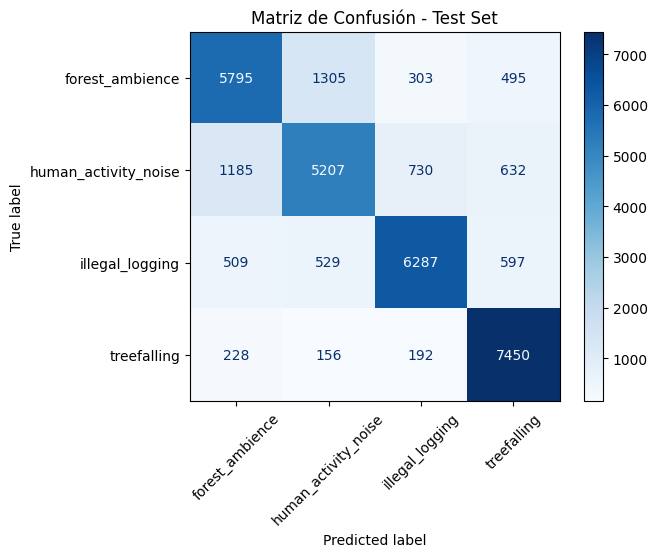

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluar en el set de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte detallado
target_names = classes

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=target_names, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión - Test Set")
plt.show()

In [18]:
from scipy.signal import resample_poly
import numpy as np

def predict_audio_file(file_path, model, config, classes, X_min, X_max, target_frames,
                       window_stride=None, top_k=3, verbose=False):

    # 1) Cargar
    rate, wav = wavfile.read(file_path)

    # 2) mono y float32
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = wav.astype(np.float32)

    # 4) ventana y stride
    if window_stride is None:
        window_stride = config.step // 2  # 50% overlap (puedes cambiar)

    preds_list = []

    # si el audio es más corto que config.step, hacemos un único padding
    if wav.shape[0] <= config.step:
        seg = np.pad(wav, (0, config.step - wav.shape[0]), mode='constant')
        starts = [0]
    else:
        starts = list(range(0, wav.shape[0] - config.step + 1, window_stride))
        # incluir última ventana para cubrir cola
        if (wav.shape[0] - config.step) % window_stride != 0:
            starts.append(wav.shape[0] - config.step)

    for s in starts:
        seg = wav[s:s + config.step]
        if seg.shape[0] < config.step:
            seg = np.pad(seg, (0, config.step - seg.shape[0]), mode='constant')

        # extraer MFCC (misma llamada que en build_rand_feat)
        mfcc_feat = mfcc(seg, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T

        # padding/truncado temporal a target_frames (mismo comportamiento que en build_rand_feat)
        if mfcc_feat.shape[1] < target_frames:
            pad_w = target_frames - mfcc_feat.shape[1]
            mfcc_feat = np.pad(mfcc_feat, ((0,0),(0,pad_w)), mode='constant')
        elif mfcc_feat.shape[1] > target_frames:
            mfcc_feat = mfcc_feat[:, :target_frames]

        # Normalizar usando X_min/X_max del entrenamiento (scalar)
        mfcc_norm = (mfcc_feat - X_min) / (X_max - X_min + 1e-9)

        # Preparar input según modo
        if config.mode == 'conv':
            x_in = mfcc_norm.reshape(1, mfcc_norm.shape[0], mfcc_norm.shape[1], 1)
        elif config.mode == 'time':
            x_in = mfcc_norm.T.reshape(1, mfcc_norm.shape[1], mfcc_norm.shape[0])
        elif config.mode == 'vector':
            x_in = np.mean(mfcc_norm, axis=1).reshape(1, -1)
        else:
            raise ValueError("config.mode debe ser 'conv','time' o 'vector'")

        # Predecir y guardar softmax vector
        prob = model.predict(x_in, verbose=0)[0]
        preds_list.append(prob)

    # Promediar probabilidades (soft-voting)
    preds_arr = np.array(preds_list)
    avg_prob = preds_arr.mean(axis=0)

    # Top-k
    top_idx = avg_prob.argsort()[-top_k:][::-1]
    top_results = [(classes[i], float(avg_prob[i])) for i in top_idx]


    # info adicional
    if verbose:
        print(f"Num ventanas: {len(preds_list)}, stride (samples): {window_stride}")
        for cls, p in top_results:
            print(f"{cls}: {p:.4f}")

    return top_results, avg_prob

# Ejemplo de uso:
# Asegúrate de usar 'classes' en el mismo orden que el used para to_categorical (p. ej. classes = list(np.unique(df.label)))
# X_min, X_max, target_frames vienen de: X, y, X_min, X_max, target_frames = build_rand_feat()
file_path = "dataset_wavfiles/0pgG7Rk_eqM_140.0_150.0_chainsaw.wav"
top_results, avg_prob = predict_audio_file(file_path, model, config, classes, X_min, X_max, target_frames, verbose=True)
print("Top resultados:", top_results)

Num ventanas: 1198, stride (samples): 800
illegal_logging: 0.6894
treefalling: 0.2780
human_activity_noise: 0.0294
Top resultados: [('illegal_logging', 0.6893928050994873), ('treefalling', 0.2780124247074127), ('human_activity_noise', 0.029422540217638016)]


In [19]:
import tensorflow as tf
import os

# Guardar el modelo en formato Keras (.keras)
model.save("LSTM_model.keras")
print("Modelo guardado en: LSTM_model.keras")

# Cargar el modelo para pasarlo al conversor
loaded_model = tf.keras.models.load_model("LSTM_model.keras")

# Crear conversor
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)

# Permitir ops de TensorFlow (necesario por las LSTM)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Operaciones nativas TFLite
    tf.lite.OpsSet.SELECT_TF_OPS     # Operaciones de TensorFlow
]

# Desactivar intento de bajar TensorList
converter._experimental_lower_tensor_list_ops = False

# Convertir
tflite_model = converter.convert()

# Guardar modelo convertido
tflite_path = "LSTM_model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

# Comparación de tamaños
size_original = os.path.getsize("LSTM_model.keras")
size_tflite = os.path.getsize(tflite_path)

print(f"Tamaño .keras:  {size_original / 1024:.2f} KB")
print(f"Tamaño TFLite:  {size_tflite / 1024:.2f} KB")
print(f"Reducción:      {100 * (1 - size_tflite/size_original):.2f}%")




Modelo guardado en: LSTM_model.keras
INFO:tensorflow:Assets written to: C:\Users\W11\AppData\Local\Temp\tmpzi5sw0zc\assets


INFO:tensorflow:Assets written to: C:\Users\W11\AppData\Local\Temp\tmpzi5sw0zc\assets


Saved artifact at 'C:\Users\W11\AppData\Local\Temp\tmpzi5sw0zc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8, 13), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2173588950480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175456083408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175456082448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175456083024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175456081680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2173575662288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2173575661328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2173575661712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2173575661520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2173575660176: TensorSpec(shape=(), dtype=tf.resource, name=None)
Tamaño .keras: